In [72]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import complexPyTorch as ctorch
from complexPyTorch import complexFunctions, complexLayers
from complexPyTorch.complexFunctions import complex_tanh

plt.rcParams['text.usetex']=True

In [73]:
delta=0.01
mass=1

In [74]:
class BosonWaveFunction(nn.Module):
    def __init__(self):
        super(BosonWaveFunction, self).__init__()

        self.layer1=nn.Linear(1,32)
        self.layer2=nn.Linear(32,32)
        self.layer3=nn.Linear(32,1)

        self.norm = torch.ones(1, requires_grad=False)

    def forward(self, inputs):
        x = inputs
        x = self.layer1(x)
        x = torch.tanh(x)
        x = self.layer2(x)
        x = torch.tanh(x)
        x = self.layer3(x)

        # boundary condition - normalization?
        # boundary_condition = self.exp(inputs)
        # output = self.norm*x*boundary_condition
        
        x = torch.mul(x,self.norm)

        return x
    
    def update_norm(self, inputs):
        with torch.no_grad():
            value = self.forward(inputs)
            N = value**2
            print(N)
            delta=inputs[1]-inputs[0]
            N=torch.sum(N)*delta 
            self.norm = self.norm*1.0/torch.sqrt(N)

In [75]:
class FermionWaveFunction(nn.Module):
    def __init__(self):
        super(FermionWaveFunction, self).__init__()

        self.layer1=ctorch.complexLayers.ComplexLinear(1,32)
        self.layer2=ctorch.complexLayers.ComplexLinear(32,32)
        self.layer3=ctorch.complexLayers.ComplexLinear(32,1)

        self.norm = torch.ones(1, requires_grad=False)

    def forward(self, inputs):
        x = inputs.type(torch.complex64)
        x = self.layer1(x)
        x = ctorch.complexFunctions.complex_tanh(x)
        x = self.layer2(x)
        x = ctorch.complexFunctions.complex_tanh(x)
        x = self.layer3(x)

        # boundary condition - normalization?
        # boundary_condition = self.exp(inputs)
        # output = self.norm*x*boundary_condition
        
        x = torch.mul(x,self.norm)

        return x

    def update_norm(self, inputs):
        with torch.no_grad():
            value = self.forward(inputs)
            N = torch.mul(value.conj(),value)
            delta=inputs[1]-inputs[0]
            N=torch.sum(N)*delta
            self.norm = self.norm*1.0/torch.sqrt(N)

In [76]:
# This is preparing input data that is differentiable:
_x = np.arange(-10, 10, delta, dtype=np.float32)
_x = _x.reshape((_x.shape[0], 1))
x = torch.tensor(_x, requires_grad=True)

In [77]:
phi = BosonWaveFunction()
print(phi.norm)
phi.update_norm(x)
print(phi.norm)
phi_y = phi(x)

tensor([1.])
tensor([[0.2398],
        [0.2398],
        [0.2398],
        ...,
        [0.0750],
        [0.0750],
        [0.0750]])
tensor([0.6236])


In [78]:
psi = FermionWaveFunction()
print(psi.norm)
psi.update_norm(x)
print(psi.norm)
psi_y = psi(x)

tensor([1.])
tensor([0.7840+0.j])


/home/chris/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


/home/chris/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


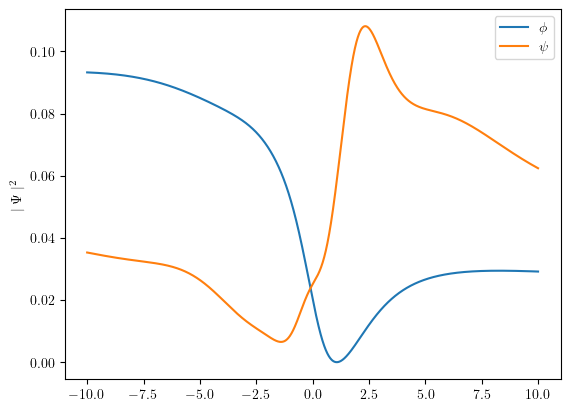

In [85]:
plt.plot(x.detach().numpy(), (phi_y**2).detach().numpy(), label=r'$\phi$')
plt.plot(x.detach().numpy(), (psi_y.conj()*psi_y).detach().numpy(), label=r'$\psi$')
plt.ylabel(r'$\mid\Psi\mid^2$')
plt.legend()
plt.show()

In [86]:
type(phi_y)

torch.Tensor

In [106]:
def linear_potential(boson_wf, inputs):
    return boson_wf(inputs)

# I could auto differentiate?!?!?????
def linear_potential_prime(boson_wf, inputs):
    phi = boson_wf(inputs)
    return torch.tensor([1 for n in range(phi.shape[0])])

def bosonic_kinetic_energy(boson_wf, inputs, delta):
    phi = boson_wf(inputs) # phi(x)
    dPhidx = torch.autograd.grad(phi, inputs=inputs, grad_outputs=torch.ones_like(phi))

    t1 = dPhidx[0]**2/(2.0*delta) # p_n^2/2a
    t2 = ((phi.roll(1)-phi.roll(-1))/2.0*delta)**2 #(phi_{n+1}-phi_{n-1})^2/2a

    return torch.sum(t1) + (delta/2.0)*torch.sum(t2)

def boson_potential_energy(boson_wf, inputs, delta, potential):
    phi = boson_wf(inputs)

    t1 = potential(boson_wf, inputs)**2 # V(phi_n)^2
    t2 = potential(boson_wf, inputs)*(phi.roll(1)-phi.roll(-1)) # V(phi_n)*(phi_{n+1}-phi_{n-1})

    return (delta/2.0)*torch.sum(t1) + (1.0/2.0)*torch.sum(t2)

def fermion_kinetic_energy(fermion_wf, inputs, delta):
    chi = fermion_wf(inputs)

    t1 = (chi.conj())*(chi.roll(1))
    t2 = (chi.conj().roll(1))*chi

    return (torch.sum(t1)+torch.sum(t2))/(2.0*delta)

def fermion_potential_energy(fermion_wf, boson_wf, inputs, delta, potential_prime):
    chi = fermion_wf(inputs)

    minus1n = torch.tensor([(-1)**n for n in range(chi.shape[0])])
    half = torch.tensor([0.5 for n in range(chi.shape[0])])

    return torch.sum(minus1n*potential_prime(boson_wf,inputs)*(chi.conj()*chi-half))

In [107]:
print(bosonic_kinetic_energy(phi, x, delta))
print(boson_potential_energy(phi, x, delta, linear_potential))
print(fermion_kinetic_energy(psi, x, delta))
print(fermion_potential_energy(psi, phi, x, delta, linear_potential_prime))

tensor(195.9400, grad_fn=<AddBackward0>)
tensor(0.5000, grad_fn=<AddBackward0>)
tensor(9999.2275+0.j, grad_fn=<DivBackward0>)
tensor(0.+0.j, grad_fn=<SumBackward0>)


/home/chris/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [110]:
print(bosonic_kinetic_energy(phi, x, delta) \
    + boson_potential_energy(phi, x, delta, linear_potential) \
    + fermion_kinetic_energy(psi, x, delta) \
    + fermion_potential_energy(psi, phi, x, delta, linear_potential_prime))

tensor(10195.6680+0.j, grad_fn=<AddBackward0>)


/home/chris/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [113]:
def total_energy(boson_wf, fermion_wf, inputs, delta, potential, potential_prime):
    bosonKE = bosonic_kinetic_energy(boson_wf, inputs, delta)
    bosonPE = boson_potential_energy(boson_wf, inputs, delta, potential)
    fermionKE = fermion_kinetic_energy(fermion_wf, inputs, delta)
    fermionPE = fermion_potential_energy(fermion_wf, boson_wf, inputs, delta, potential_prime)

    return bosonKE + bosonPE + fermionKE + fermionPE

In [114]:
total_energy(phi, psi, x, delta, linear_potential, linear_potential_prime)

/home/chris/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor(10195.6680+0.j, grad_fn=<AddBackward0>)

In [117]:
bosonOptimizer = torch.optim.Adam(phi.parameters(), lr=0.0001)
fermionOptimizer = torch.optim.Adam(psi.parameters(), lr=0.0001)

bosonOptimizer.zero_grad()
fermionOptimizer.zero_grad()

# cant go up to 10000?
for i in range(100):
    phi.update_norm(x)
    psi.update_norm(x)

    energy=total_energy(phi,psi,x,delta,linear_potential,linear_potential_prime) # this is the loss!
    energy.backward()

    bosonOptimizer.step()
    fermionOptimizer.step()
    bosonOptimizer.zero_grad()
    fermionOptimizer.zero_grad()
    
    if i%1==0:
        print(energy)

tensor([[0.0932],
        [0.0932],
        [0.0932],
        ...,
        [0.0292],
        [0.0292],
        [0.0292]])


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.